In [1]:
using DataFrames
using Chemfiles
using Gadfly
using Cairo
using Compose
set_default_plot_size(40cm, 14cm)

home = "/home/german/labo/18/egfr/modos/"
rehome = "/home/german/labo/18/egfr/gram/"
aa = 277

277

In [2]:
function tognm(vtor_anm)
    vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

tognm (generic function with 1 method)

In [3]:
function qgrammian0(mtx_1, mtx_2, weight_1 = 0)
    # Projects mtx_1 onto mtx_2 and gets the mean of the elements in the diagonal.
    if size(mtx_1)[1] != size(mtx_2)[1]
        println("Length of matrices columns must be the same. Aborting.")
        return 0
    end
    
    mtx_g = transpose(mtx_1) * mtx_2 * transpose(mtx_2) * mtx_1
      
    if weight_1 != 0
        # Weights were specified
        if length(weight_1) != size(mtx_1)[2]
            println("There must be as many weights as columns. Aborting.")
            return 0
        end
        weighted = diag(mtx_g) .* weight_1
        zeta = sum(weighted)
    else
        zeta = mean(diag(mtx_g))   
    end
    
    
    return zeta
end

qgrammian0 (generic function with 2 methods)

# Arranco

In [4]:
# Leo nombres de structuras
tmp = readdlm(string(rehome, "/pdbs.list"))
pdbs_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));
aa = 277
aa_3 = aa * 3
aa_36 = aa_3 - 6
structs = length(pdbs_list)

# Leo activas e inactivas
tmp = readdlm(string(rehome, "/am.list"))
am_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

tmp = readdlm(string(rehome, "/im.list"))
im_list = convert(Array{String, 1}, reshape(tmp, length(tmp)));

In [5]:
# Leo nonmissing residuos de pocket
tmp = readdlm(string(rehome, "nonmis_aa_pocket"))
nonmis_aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(nonmis_aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

nonmis_aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    nonmis_aa_pocket_3[3*i - 2] = nonmis_aa_pocket[i] * 3
    nonmis_aa_pocket_3[3*i - 1] = nonmis_aa_pocket[i] * 3 + 1
    nonmis_aa_pocket_3[3*i] = nonmis_aa_pocket[i] * 3 + 2
end

# Leo todos los residuos de pocket
tmp = readdlm(string(rehome, "aa_pocket"))
aa_pocket = convert(Array{Int64, 1}, reshape(tmp, length(tmp)))

aa_pocket_nonmis = length(aa_pocket)
aa_3_pocket_nonmis = aa_pocket_nonmis * 3

aa_pocket_3 = Array{Int64}(aa_3_pocket_nonmis)
for i = 1:aa_pocket_nonmis
    aa_pocket_3[3*i - 2] = aa_pocket[i] * 3
    aa_pocket_3[3*i - 1] = aa_pocket[i] * 3 + 1
    aa_pocket_3[3*i] = aa_pocket[i] * 3 + 2
end

## Versión con los residuos nonmissing del pocket

In [6]:
am_pesos_nonmis = Array{Float64, 2}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]

    am_pesos_nonmis[:, i] = [ sum(modos[nonmis_aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    am_pesos_nonmis[:, i] = am_pesos_nonmis[:, i] ./ sum(am_pesos_nonmis[:, i]);
end

In [16]:
im_pesos_nonmis = Array{Float64, 2}(aa_36, length(im_list))
tmp_bftors = Array{Float64, 2}(length(nonmis_aa_pocket), aa_36)

for i = 1:length(im_list)
    each = im_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    tmp = [ modos[nonmis_aa_pocket_3, k] .^ 2 ./ freq[k] for k = 1:aa_36 ]
    for k = 1:aa_36
        ii = 0
        for j = 1:3:length(nonmis_aa_pocket_3)
            ii += 1
            tmp_bftors[ii, k] = sum(tmp[k][j:j+2])
        end
    end

    tmp_bftors_each_aa = mapslices(x -> sum(x), tmp_bftors, 2)
    tmp_bftors_each_mode = mapslices(x -> sum(x), tmp_bftors, 1)
    
    im_pesos_nonmis[:, i] = tmp_bftors_each_mode ./ sum(tmp_bftors_each_aa)
end

## Versión con todos los residuos del pocket

In [15]:
am_pesos = Array{Float64, 2}(aa_36, length(am_list))

for i = 1:length(am_list)
    each = am_list[i]

    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]

    am_pesos[:, i] = [ sum(modos[aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    am_pesos[:, i] = am_pesos[:, i] ./ sum(am_pesos[:, i]);
end

In [9]:
im_pesos = Array{Float64, 2}(aa_36, length(im_list))

for i = 1:length(im_list)
    each = im_list[i]
    
    freq = readdlm(string(home, each, "/", "freq_", each))[8:end, 1]
    freq = convert(Array{Float64, 1}, freq)
    modos = readdlm(string(rehome, each, "/", "modos_", each))[:, 1:aa_36]
    
    im_pesos[:, i] = [ sum(modos[aa_pocket_3, k] .^ 2 ./ freq[k]) for k = 1:aa_36 ]
    im_pesos[:, i] = im_pesos[:, i] ./ sum(im_pesos[:, i]);
end

# Grafico

In [17]:
vec_im_pesos = mapslices(x -> mean(x), im_pesos_nonmis, 2)
vec_im_pesos = reshape(vec_im_pesos, length(vec_im_pesos))
vec_am_pesos = mapslices(x -> mean(x), am_pesos, 2)
vec_am_pesos = reshape(vec_am_pesos, length(vec_am_pesos))

df_pesos_nonmis = DataFrame(Weights = [ vec_im_pesos ./ vec_im_pesos[1] ; vec_am_pesos ./ vec_am_pesos[1]], 
    Modes = [ collect(1:aa_36) ; collect(1:aa_36) ],
    Conformer = repeat(["IM" ; "AM"], inner = [ aa_36]));

In [18]:
vec_im_pesos = mapslices(x -> mean(x), im_pesos, 2)
vec_im_pesos = reshape(vec_im_pesos, length(vec_im_pesos))
vec_am_pesos = mapslices(x -> mean(x), am_pesos, 2)
vec_am_pesos = reshape(vec_am_pesos, length(vec_am_pesos))

df_pesos = DataFrame(Weights = [ vec_im_pesos ./ vec_im_pesos[1] ; vec_am_pesos ./ vec_am_pesos[1]], 
    Modes = [ collect(1:aa_36) ; collect(1:aa_36) ],
    Conformer = repeat(["IM" ; "AM"], inner = [ aa_36]));

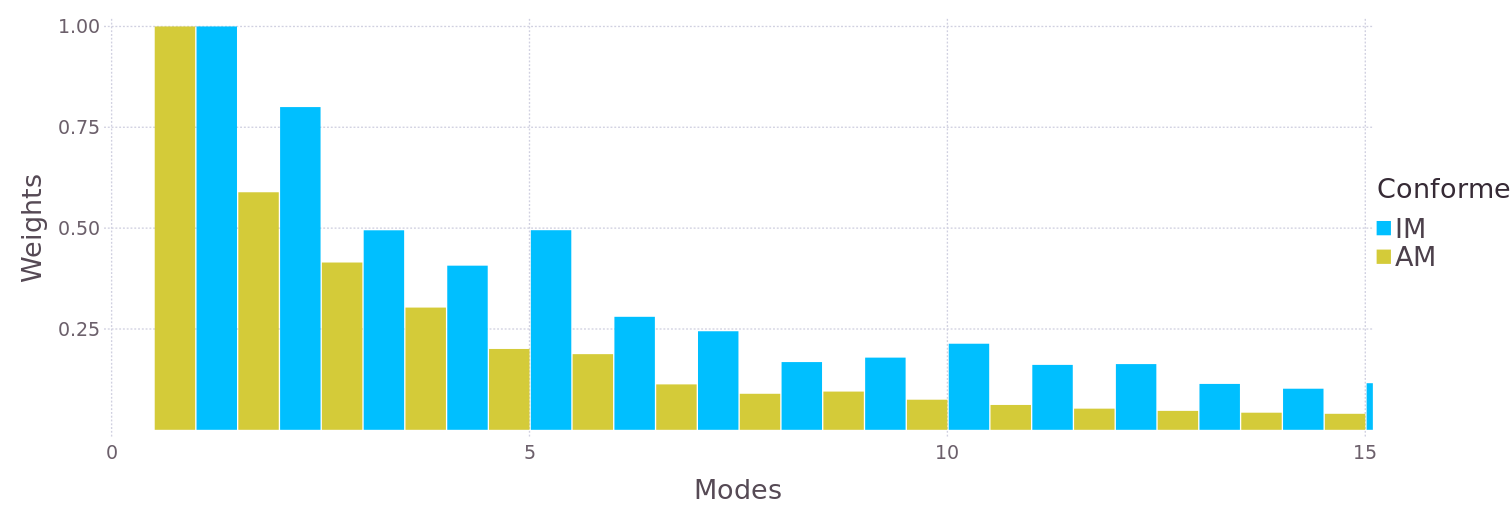

In [19]:
pdf_pesos_nonmis = plot(df_pesos_nonmis, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical), 
    Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

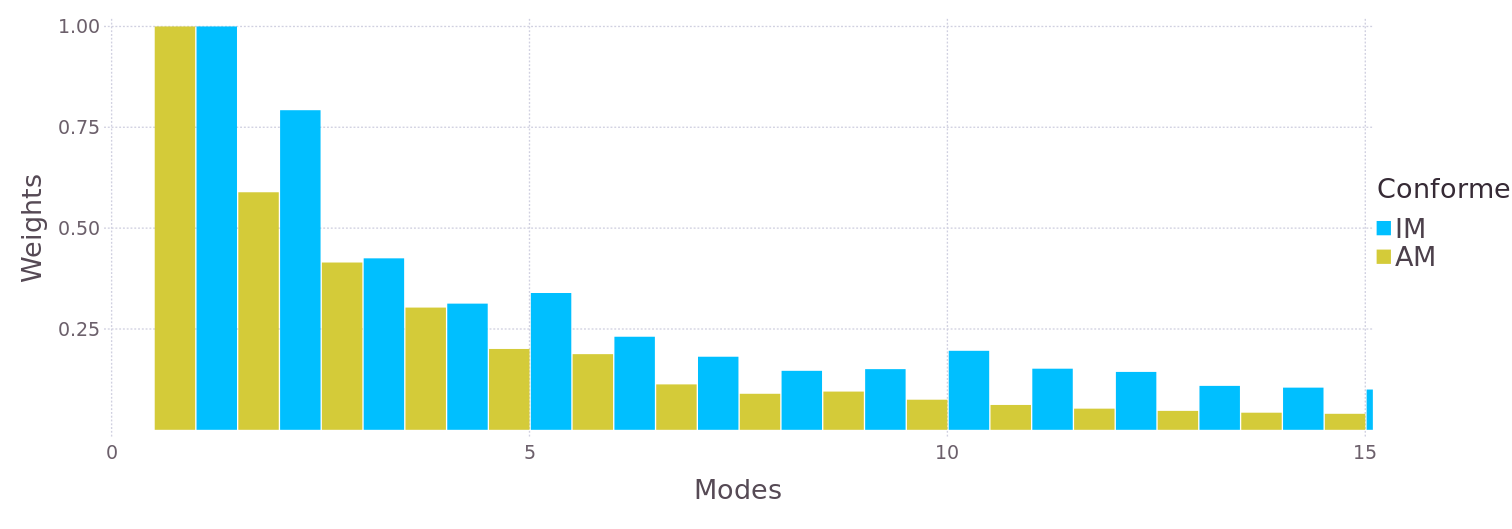

In [20]:
pdf_pesos = plot(df_pesos, x="Modes", y="Weights", color = "Conformer", Geom.bar(position = :dodge),

    #Guide.title("Figure 2.AA"),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.yticks(ticks = collect(0.25:0.25:1.0)),
    Coord.cartesian(xmin = 0, xmax = 15),

    Theme(bar_spacing = 2pt, grid_line_width=1pt, key_label_font_size = 20pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))